In [22]:
import numpy as np
import os
import xraydb
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from scipy.optimize import curve_fit
import glob
import re
import pathlib
from tqdm.auto import tqdm
import numpy as np
import dask.array as da
from scipy.spatial.distance import pdist, squareform
import xraydb
from dask.distributed import Client
from concurrent.futures import ThreadPoolExecutor, as_completed
import numexpr as ne
from scipy.signal import convolve
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from numpy.fft import fftn, fftshift

In [23]:
%matplotlib inline
ptable = {
    'H': 1, 'He': 2,
    'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
    'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18,
    'K': 19, 'Ca': 20, 'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26, 
    'Co': 27, 'Ni': 28, 'Cu': 29, 'Zn': 30, 'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 
    'Br': 35, 'Kr': 36, 'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40, 'Nb': 41, 'Mo': 42, 
    'Tc': 43, 'Ru': 44, 'Rh': 45, 'Pd': 46, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
    'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56, 'La': 57, 'Ce': 58, 
    'Pr': 59, 'Nd': 60, 'Pm': 61, 'Sm': 62, 'Eu': 63, 'Gd': 64, 'Tb': 65, 'Dy': 66,
    'Ho': 67, 'Er': 68, 'Tm': 69, 'Yb': 70, 'Lu': 71, 'Hf': 72, 'Ta': 73, 'W': 74, 
    'Re': 75, 'Os': 76, 'Ir': 77, 'Pt': 78, 'Au': 79, 'Hg': 80, 'Tl': 81, 'Pb': 82,
    'Bi': 83, 'Po': 84, 'At': 85, 'Rn': 86, 'Fr': 87, 'Ra': 88, 'Ac': 89, 'Th': 90,
    'Pa': 91, 'U': 92
}

atomic_masses = {
    'H': 1.0, 'He': 4.0, 'Li': 6.9, 'Be': 9.0, 'B': 10.8, 'C': 12.0, 'N': 14.0, 'O': 16.0,
    'F': 19.0, 'Ne': 20.2, 'Na': 22.9, 'Mg': 24.3, 'Al': 26.9, 'Si': 28.1, 'P': 30.9, 'S': 32.1,
    'Cl': 35.4, 'Ar': 39.9, 'K': 39.1, 'Ca': 40.1, 'Sc': 44.9, 'Ti': 47.9, 'V': 50.9, 'Cr': 52.0,
    'Mn': 54.9, 'Fe': 55.8, 'Co': 58.9, 'Ni': 58.7, 'Cu': 63.5, 'Zn': 65.4, 'Ga': 69.7, 'Ge': 72.6,
    'As': 74.9, 'Se': 79.0, 'Br': 79.9, 'Kr': 83.8, 'Rb': 85.5, 'Sr': 87.6, 'Y': 88.9, 'Zr': 91.2,
    'Nb': 92.9, 'Mo': 95.9, 'Tc': 98.0, 'Ru': 101.1, 'Rh': 102.9, 'Pd': 106.4, 'Ag': 107.9, 'Cd': 112.4,
    'In': 114.8, 'Sn': 118.7, 'Sb': 121.8, 'Te': 127.6, 'I': 126.9, 'Xe': 131.3, 'Cs': 132.9, 'Ba': 137.3,
    'La': 138.9, 'Ce': 140.1, 'Pr': 140.9, 'Nd': 144.2, 'Pm': 145.0, 'Sm': 150.4, 'Eu': 152.0, 'Gd': 157.3,
    'Tb': 158.9, 'Dy': 162.5, 'Ho': 164.9, 'Er': 167.3, 'Tm': 168.9, 'Yb': 173.0, 'Lu': 175.0, 'Hf': 178.5,
    'Ta': 180.9, 'W': 183.8, 'Re': 186.2, 'Os': 190.2, 'Ir': 192.2, 'Pt': 195.1, 'Au': 197.0, 'Hg': 200.6,
    'Tl': 204.4, 'Pb': 207.2, 'Bi': 208.9, 'Po': 209.0, 'At': 210.0, 'Rn': 222.0, 'Fr': 223.0, 'Ra': 226.0,
    'Ac': 227.0, 'Th': 232.0, 'Pa': 231.0, 'U': 238.0
}

In [24]:
def giwaxs_simulation(xyz_path, sigma, voxel_size):
    """
    Calculates the scattering intensity I(q) for a given molecular structure in an xyz file,
    concentration, and background solvent electron density. Molecular volume is calculated via
    convex hull and background solvent essentially subtracts "z" from each atom in molecule. 
    Note, atoms with Z/(volume/#atoms) less than solvent electron density are removed. 
    Complexity is O(n) for number of q-values and O(n^2) for the number of atoms in .xyz file

    Parameters:
    - xyz_path: string, path to xyz file of molecule, NP, etc
    - qs: 1D array of q values which you would like intensity to be calculated
    - vol_pct: float, volume percent of molecule in solution
    - solvent_edens: float, electron density of solvent in e/Å^3
    - plot_hull: boolean 

    Returns:
    -iq_vals: 1D numpy array of absolute intesntiy values for each q in exp_file
    """
    # Extracting the atomic symbols and positions from the xyz file
    with open(xyz_path, 'r') as file:
        lines = file.readlines()
    # Extracting atom data
    atom_data = [line.split() for line in lines[2:] if len(line.split()) == 4]
    symbols, coords = zip(*[(parts[0], np.array(list(map(float, parts[1:])))) for parts in atom_data])

    # Shift coords array to origin (buffer ensures room for Gaussian smearing)
    coords = np.array(coords)
    buffer = 4
    coords[:,0] -= np.min(coords[:,0])-buffer
    coords[:,1] -= np.min(coords[:,1])-buffer
    coords[:,2] -= np.min(coords[:,2])-buffer

    # Constants and Grid
    grid_size_x = int(np.ceil((np.max(coords[:,0])+buffer)/voxel_size))
    grid_size_y = int(np.ceil((np.max(coords[:,1])+buffer)/voxel_size))
    grid_size_z = int(np.ceil((np.max(coords[:,2])+buffer)/voxel_size))

    # Create an empty grid
    density_grid = np.zeros((grid_size_x, grid_size_y, grid_size_z))
    
    # Populate the grid
    num_electrons = np.array([ptable[symbol] for symbol in symbols])
    for coord, symbol in zip(coords, symbols):
        grid_coord = (coord / voxel_size).astype(int)
        density_grid[grid_coord[0], grid_coord[1], grid_coord[2]] += (ptable[symbol])*voxel_size**3
        
    # Create a Gaussian kernel
    sigma_voxel = sigma/voxel_size
    kernel_size = 6 * sigma_voxel + 1  # Ensure the kernel size covers enough of the Gaussian
    gaussian_kernel_3d = gaussian_kernel(kernel_size, sigma)
    # print('1')
    density_grid = convolve(density_grid, gaussian_kernel_3d, mode='same')

    # Compute the Fourier transform of the density grid
    ft_density = fftn(density_grid)
    ft_density_shifted = fftshift(ft_density)  # Shift the zero-frequency component to the center of the spectrum

    # Calculate 3D q-values
    nx, ny, nz = ft_density_shifted.shape
    qx = np.fft.fftfreq(nx, d=voxel_size) * 2 * np.pi
    qy = np.fft.fftfreq(ny, d=voxel_size) * 2 * np.pi
    qz = np.fft.fftfreq(nz, d=voxel_size) * 2 * np.pi
    qx, qy, qz = np.meshgrid(qx, qy, qz, indexing='ij')
    q = np.sqrt(qx**2 + qy**2 + qz**2)
    
    # Magnitude squared of the Fourier transform for scattering intensity I(q)
    iq = np.abs(ft_density_shifted)**2
    
    return q, iq, density_grid

def load_xyz(xyz_path):
    """
    Parameters:
    - xyz_path: string, path to xyz file of molecule, NP, etc

    Returns:
    -coords: 2D numpy array of x,y,z coordinates
    -elements: 1D numpy array of element species for each coord in coords
    """
    # Extracting the atomic symbols and positions from the xyz file
    with open(xyz_path, 'r') as file:
        lines = file.readlines()
    # Extracting atom data
    atom_data = [line.split() for line in lines[2:] if len(line.split()) == 4]
    symbols, coords = zip(*[(parts[0], np.array(list(map(float, parts[1:])))) for parts in atom_data])

    coords = np.array(coords)
    elements = np.array(symbols)
    
    return coords, elements

def write_xyz(output_path, coords, elements):
    """
    Writes the molecular structure to an xyz file at the specified path.
    
    Parameters:
    - output_path: string, path where the xyz file will be saved
    - coords: 2D numpy array of x, y, z coordinates
    - elements: 1D numpy array of element symbols corresponding to each row in coords
    """
    if len(coords) != len(elements):
        raise ValueError("Length of coordinates and elements must be the same.")

    # Start writing to the file
    with open(output_path, 'w') as file:
        # Write the number of atoms on the first line
        file.write(f"{len(elements)}\n")
        # Write a comment or blank line on the second line
        file.write("XYZ file generated by write_xyz function\n")

        # Write elements and coordinates to the file
        for element, (x, y, z) in zip(elements, coords):
            file.write(f"{element} {x:.8f} {y:.8f} {z:.8f}\n")

def calc_edens(molec_formula, mass_density):
    """
    molec_formula: str type with format 'Pb1I6' Must include number after each symbol
    mass_density: float type given in g/cm3
    """
    pattern = r'([A-Z][a-z]?)(\d*)'
    tot_electrons = 0
    tot_molarmass = 0 
    for element, count in re.findall(pattern, molec_formula):
        # Convert count to integer, defaulting to 1 if not specified
        count = int(count) if count else 1
        # Lookup atomic number and calculate electrons
        atomic_number = ptable[element]
        molarmass = atomic_masses[element]
        if atomic_number:
            tot_electrons += atomic_number * count
        else:
            raise ValueError(f'Element {element} not found in ptable dictionary.')
        if molarmass:
            tot_molarmass += molarmass * count
        else:
            raise ValueError(f'Element {element} not found in molar mass dictionary.')
            
    molecular_volume = (tot_molarmass/mass_density)*(1e24/6.02e23) #Å^3
    electron_dens = tot_electrons/molecular_volume
    
    return electron_dens

In [221]:
def gaussian_kernel(size, sigma=1):
    """ Returns a normalized 3D gauss kernel array for convolutions """
    size = int(size) // 2
    x, y, z = np.mgrid[-size:size+1, -size:size+1, -size:size+1]
    g = np.exp(-(x**2 + y**2 + z**2) / (2 * sigma**2))
    return g / g.sum()
    
def generate_density_grid(xyz_path, sigma, voxel_size):
    """
    ...

    Parameters:
    - xyz_path: string, path to xyz file of molecule, NP, etc
    - sigma: peak width where FWHM=2 sqrt(2ln(2)) * sigma

    Returns:
    -iq_vals: 1D numpy array of absolute intesntiy values for each q in exp_rfile
    """
    # Extracting the atomic symbols and positions from the xyz file
    with open(xyz_path, 'r') as file:
        lines = file.readlines()
    # Extracting atom data
    atom_data = [line.split() for line in lines[2:] if len(line.split()) == 4]
    symbols, coords = zip(*[(parts[0], np.array(list(map(float, parts[1:])))) for parts in atom_data])

    # Shift coords array to origin (buffer ensures room for Gaussian smearing)
    coords = np.array(coords)
    buffer = 4
    coords[:,0] -= np.min(coords[:,0])-buffer
    coords[:,1] -= np.min(coords[:,1])-buffer
    coords[:,2] -= np.min(coords[:,2])-buffer

    # Constants and Grid
    grid_size_x = int(np.ceil((np.max(coords[:,0])+buffer)/voxel_size))
    grid_size_y = int(np.ceil((np.max(coords[:,1])+buffer)/voxel_size))
    grid_size_z = int(np.ceil((np.max(coords[:,2])+buffer)/voxel_size))

    # Create an empty grid
    density_grid = np.zeros((grid_size_x, grid_size_y, grid_size_z))
    
    # Populate the grid
    num_electrons = np.array([ptable[symbol] for symbol in symbols])
    for coord, symbol in zip(coords, symbols):
        grid_coord = (coord / voxel_size).astype(int)
        density_grid[grid_coord[0], grid_coord[1], grid_coord[2]] += (ptable[symbol])*voxel_size**3
        
    # Create a Gaussian kernel
    sigma_voxel = sigma/voxel_size
    kernel_size = 6 * sigma_voxel + 1  # Ensure the kernel size covers enough of the Gaussian
    gaussian_kernel_3d = gaussian_kernel(kernel_size, sigma)
    # print('1')
    density_grid = convolve(density_grid, gaussian_kernel_3d, mode='same')

    # Extract the indices where g is nonzero
    # x, y, z = np.nonzero(density_grid)

    return density_grid

def plot_density_grid(density_grid, cmap, threshold_pct=98, num_levels=10):
    x, y, z = np.where(density_grid>np.percentile(density_grid, threshold_pct))
    values = density_grid[x, y, z]
    normalized_values = values / np.max(values)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Define the number of levels of opacity
    opacities = np.linspace(0.01,0.2,num_levels)

    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0.3, 1, num_levels))
    
    for i in range(num_levels):
        # Calculate the opacity for the current level
        opacity = opacities[i]
        color = colors[i]
        # Determine the data points that fall into the current opacity level
        mask = (normalized_values > (i / levels)) & (normalized_values <= ((i + 1) / levels))
        
        # Scatter plot for the current subset of data
        ax.scatter(x[mask], 
                   y[mask], 
                   z[mask], 
                   color=color,  # Use the single color for all points
                   alpha=opacity, 
                   edgecolor='none')
    
    # Set labels and titles
    ax.set_xlabel('X (voxels)')
    ax.set_ylabel('Y (voxels)')
    ax.set_zlabel('Z (voxels)')
    ax.set_title('3D Scatter Plot of Electron Density')
    
    # Setting equal aspect ratio
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0
    mid_x = (x.max()+x.min()) * 0.5
    mid_y = (y.max()+y.min()) * 0.5
    mid_z = (z.max()+z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    fig.patch.set_facecolor('black')  # Set the outer background color

    ax.set_facecolor('black')  # Set the background color of the plot
    
    # Change the color of the ticks and labels to white
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.zaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.tick_params(axis='z', colors='white')
    
    # Change grid and pane colors
    ax.xaxis.pane.set_edgecolor('white')
    ax.yaxis.pane.set_edgecolor('white')
    ax.zaxis.pane.set_edgecolor('white')
    ax.grid(color='white', linestyle='--', linewidth=0.5)

    plt.show()
    

In [218]:
%matplotlib widget

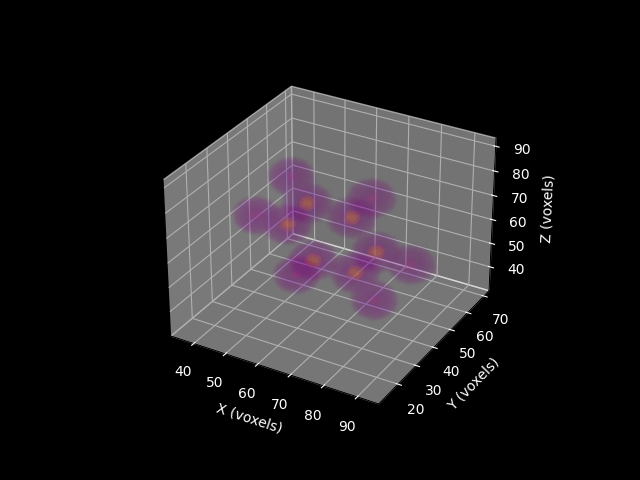

In [224]:
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/forward_sim/'
xyz_path = f'{dirr}Benzene.xyz'
sigma = 1
voxel_size = 0.1
dens_grid = generate_density_grid(xyz_path, sigma, voxel_size)
threshold = 99
num_levels=5
cmap = 'plasma'
plot_density_grid(dens_grid, cmap, threshold, num_levels)

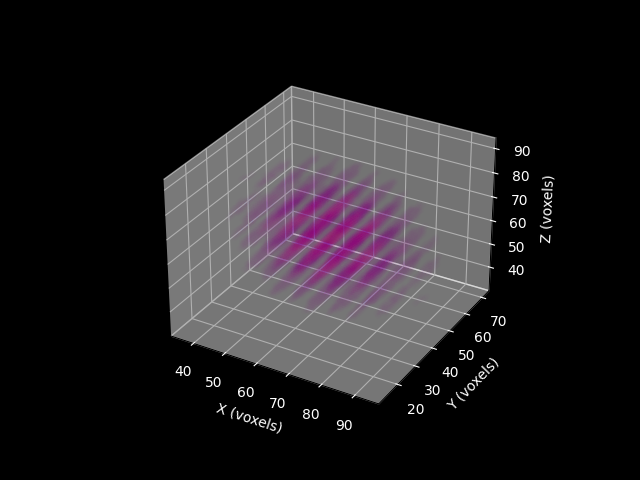

In [226]:
q, iq, density_grid = giwaxs_simulation(xyz_path, sigma, voxel_size)
threshold = 99
num_levels=20
cmap = 'plasma'
plot_density_grid(iq, cmap, threshold, num_levels)

In [227]:
np.shape(iq)

(130, 84, 124)

In [34]:
np.max(iq)

27.56250000000001

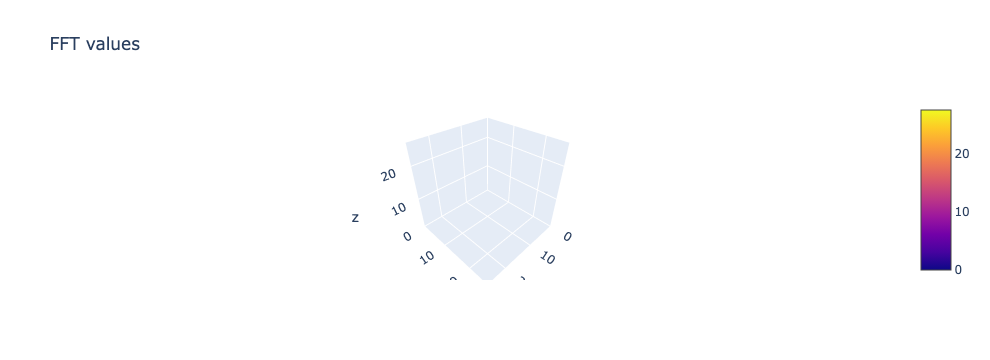

In [33]:
plot_volume(iq, 'FFT values', quantile_low=0, quantile_high=100)

In [ ]:
sigma = 1
voxel_size = 0.5
# Create a Gaussian kernel
kernel_size = 6 * sigma/voxel_size + 1  # Ensure the kernel size covers enough of the Gaussian
g = gaussian_kernel(kernel_size, sigma)
# g_down = downsample(g, 10)

plot_volume(g, 'test', quantile_low=5, quantile_high=95)

In [79]:
plt.close('all')

  0%|          | 0/10 [00:00<?, ?it/s]

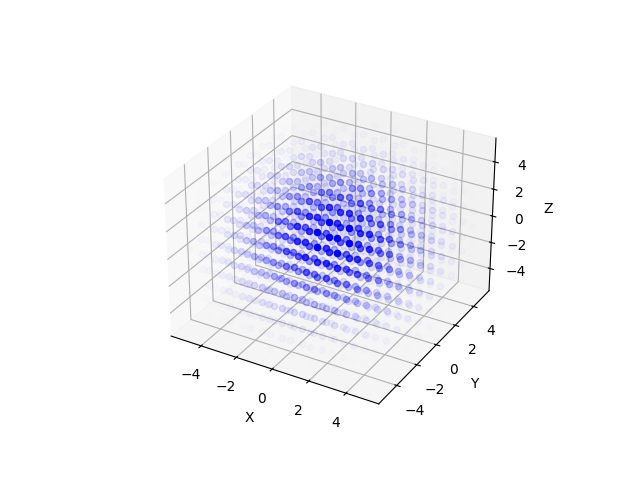

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample data
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)
z = np.linspace(-5, 5, 10)
x, y, z = np.meshgrid(x, y, z)

# Simulate some electron densities
density_grid = np.exp(-0.1*(x**2 + y**2 + z**2))

# Normalize densities to get colors and alphas
max_density = np.max(density_grid)
colors = density_grid / max_density
alphas = colors  # Simple linear mapping; adjust as needed

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with variable alpha
for i in tqdm(range(x.shape[0])):
    for j in range(x.shape[1]):
        for k in range(x.shape[2]):
            ax.scatter(x[i, j, k], y[i, j, k], z[i, j, k], color='blue', alpha=alphas[i, j, k])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [8]:
import plotly.graph_objects as go

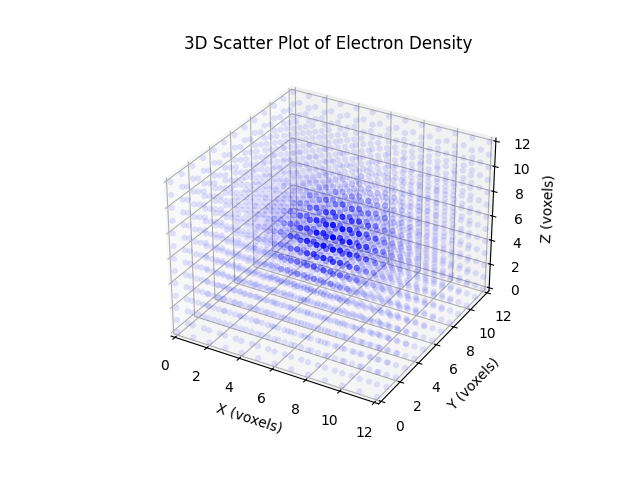

In [39]:
sigma = 2
kernel_size = int(6 * sigma + 1)
g = gaussian_kernel(kernel_size, sigma)

# Extract the indices where g is nonzero
x, y, z = np.nonzero(g)
values = g[x, y, z]
normalized_values = values / np.max(values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the number of levels of opacity
levels = 10
single_color = 'blue'  # Set a single color for all points
opacities = np.linspace(0,1,levels)
opacities = opacities**0.1
for i in range(levels):
    # Calculate the opacity for the current level
    opacity = (i + 1) / levels
    # Determine the data points that fall into the current opacity level
    mask = (normalized_values > (i / levels)) & (normalized_values <= ((i + 1) / levels))
    
    # Scatter plot for the current subset of data
    ax.scatter(x[mask], 
               y[mask], 
               z[mask], 
               color=single_color,  # Use the single color for all points
               alpha=opacity,
               edgecolor='none')

# Set labels and titles
ax.set_xlabel('X (voxels)')
ax.set_ylabel('Y (voxels)')
ax.set_zlabel('Z (voxels)')
ax.set_title('3D Scatter Plot of Electron Density')

# Setting equal aspect ratio
max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0
mid_x = (x.max()+x.min()) * 0.5
mid_y = (y.max()+y.min()) * 0.5
mid_z = (z.max()+z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()

In [ ]:
sigma = 0.5

# Create a Gaussian kernel
kernel_size = 6 * sigma + 1  # Ensure the kernel size covers enough of the Gaussian
g = gaussian_kernel(kernel_size, sigma)

# Volumetric rendering using Mayavi
# Get the indices and the corresponding Gaussian values
x, y, z = np.nonzero(g)
values = g[x, y, z]

# Normalize values for color mapping
colors = values / np.max(values)

# Plot using Mayavi
fig = mlab.figure(bgcolor=(1, 1, 1), size=(800, 600))
pts = mlab.points3d(x, y, z, colors,
                    mode='sphere',  # Change to 'point' for faster rendering
                    scale_mode='none',
                    scale_factor=0.5,
                    colormap='plasma',  # You can change this to any supported colormap
                    figure=fig)

# Update point properties for variable transparency
pts.glyph.color_mode = 'color_by_scalar'  # Use scalar value for coloring
pts.module_manager.scalar_lut_manager.lut.scale = 'linear'

# Adjusting the transparency
pts.glyph.scale_mode = 'data_scaling_off'  # Turn off scaling by scalar
pts.mlab_source.dataset.point_data.scalars = colors

# Display
mlab.show()